In this notebook, we learn another method which is similar but simpler than CAM and Grad-CAM, called Saliency Map. This method focuses on pixels, rather than features (filters of Conv2D layers).

### Imports

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

import tensorflow_hub as hub

### Building the Basic Model

Since we do not use intermediate layers in Saliency Map, the base VGG16_transfer_learning model is used without defining any new networks and adding any new outputs.

In [5]:
base_model = tf.keras.models.load_model("VGG16_transfer_learning.h5", compile=False)
base_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,0

 Total params: 14,717,762 (56.14 MB)

 Trainable params: 7,081,474 (27.01 MB)

 Non-trainable params: 7,636,288 (29.13 MB)

### Reloading Test images

The VGG_16_modified network is already trained on the cats_vs_dogs dataset through transfer learning. However, we load the test set again to visualize the results of Saliency Map and compare the results with CAM and Grad-CAM.

In [2]:
splits = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']

# load the dataset given the splits defined above
splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.FRBR87_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [3]:
labels= {
    0: "CAT",
    1: "DOG"
}

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

def format_image(image, label):
  image = tf.image.resize(image, IMAGE_SIZE) / 255.0
  return image, label

test_batches = test_examples.map(format_image).batch(1)

## Compute Gradients

You will now get the gradients of the loss with respect to the input image. This is the key step to generate the saliency later.

In [94]:
def get_gradients(image, actual_label, image_index):
    with tf.GradientTape() as tape:
        # cast image to float
        # print("Actual label before casting:\t\t\t\t{}".format(actual_label.shape))

        image = tf.cast(image, tf.float32)
        actual_label = tf.cast(actual_label, tf.float32)

        # print("Input image shape:\t\t\t\t{}".format(image.shape))

        # watch the input pixels
        tape.watch(image)

        # generate the predictions
        predictions = base_model(image)
        y_pred = predictions[:,1]

        loss = tf.keras.losses.binary_crossentropy(y_true = actual_label, y_pred = y_pred)
        print(f"Loss for one test image No.{image_index}:\t{loss}")
        gradients = tape.gradient(loss, image)
        # print("Gradient w.r.t image shape:\t\t{}".format(gradients.shape))

    return gradients

## Visualize the results

Let's now see the Saliency Map outputs. Although Saliency Map has a pixel-wise approach, there is an interesting similarity between its outputs and the outputs of feature-wise methods (CAM, Grad-CAM).

In most images, important features in CAM and Grad-CAM correspond to brighter pixels in Saliency map. This means important features are covered by bright pixels. This similarity is evident in images with 1, 2, 6, 7, 10, and 12 indices. There are also some differences; for example: In image number 8, Saliency Map has paid attention to the cats' heads, but CAM noticed the body of the black cat in predicting the label.



In [82]:
def convert_gradient_to_image(gradients):
    grads_reduced = tf.reduce_sum(tf.abs(gradients), axis=-1)
    # print("Grayscaled shape:\t{}".format(grads_reduced.shape))
    # After reducing the last dimension through summing up the
    # pixels, it is time to normalize the result.

    grads_normalized = tf.cast(
        255
        * (grads_reduced - tf.reduce_min(grads_reduced))
        / (tf.reduce_max(grads_reduced) - tf.reduce_min(grads_reduced)),
        tf.uint8,
    )

    grads_normalized = tf.squeeze(grads_normalized)
    return grads_normalized

In [91]:
def show_result(sample_img, saliency_map):
    f, ax = plt.subplots(1, 3, figsize = (18, 6))
    ax[0].imshow(sample_img[0])
    ax[0].set_title("Input Image")
    ax[0].axis('off')

    gradient_color = cv2.applyColorMap(saliency_map.numpy(), cv2.COLORMAP_HOT)
    gradient_color = gradient_color/255
    ax[1].imshow(gradient_color)
    ax[1].set_title("Saliency Map")
    ax[1].axis('off')


    super_imposed = cv2.addWeighted(sample_img.numpy()[0].astype(np.float32), 0.3, gradient_color.astype(np.float32), 0.7, 0.0)
    ax[2].imshow(super_imposed)
    ax[2].set_title("Input Image and Saliency Map Superimposed")
    ax[2].axis('off')

    plt.show()

Loss for one test image No.0:	0.49144628643989563


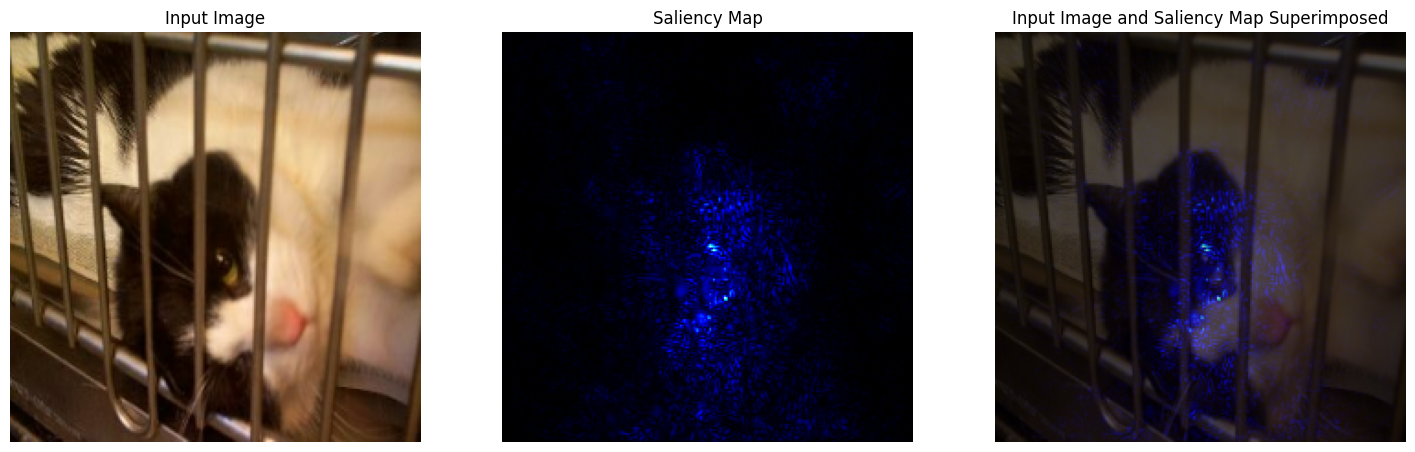

In [95]:
sample_index = 29

for img, label in test_batches.take(sample_index):
    sample_img = img
    sample_label = label

gradients = get_gradients(sample_img, sample_label, image_index = 0)
saliency_map = convert_gradient_to_image(gradients)
show_result(sample_img, saliency_map)

In [96]:
sample_index = 12
counter = 1
for img, label in test_batches.take(sample_index):
    sample_img = img
    sample_label = label
    gradients = get_gradients(sample_img, sample_label, image_index = counter)
    saliency_map = convert_gradient_to_image(gradients)
    show_result(sample_img, saliency_map)
    counter += 1

Output hidden; open in https://colab.research.google.com to view.